# Predicting Heart Disease using Machine Learning

## 1. Problem Definition
In a statement,
> Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## 2. Data
The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci

## 3. Evaluation
> If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

## 4. Features
Here, we get to see different information about each of the features in the data. I looked up some of the definition online.

**Create data dictionary**

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        * Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Models from Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
df = pd.read_csv("Heart-disease.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

## Exploratory Data Analysis (EDA)

In [5]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [6]:
# Finding out how many of each target class we have
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

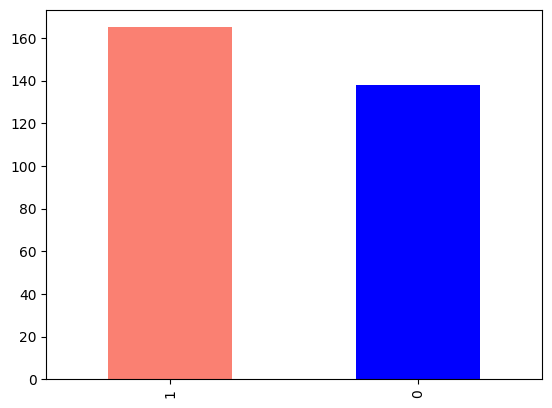

In [7]:
# Visualizing the target
df["target"].value_counts().plot(kind="bar", color=["salmon", "blue"]);

In [8]:
# Checking for missing values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [11]:
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [12]:
# Comparing the sex attribute to the target attributes
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


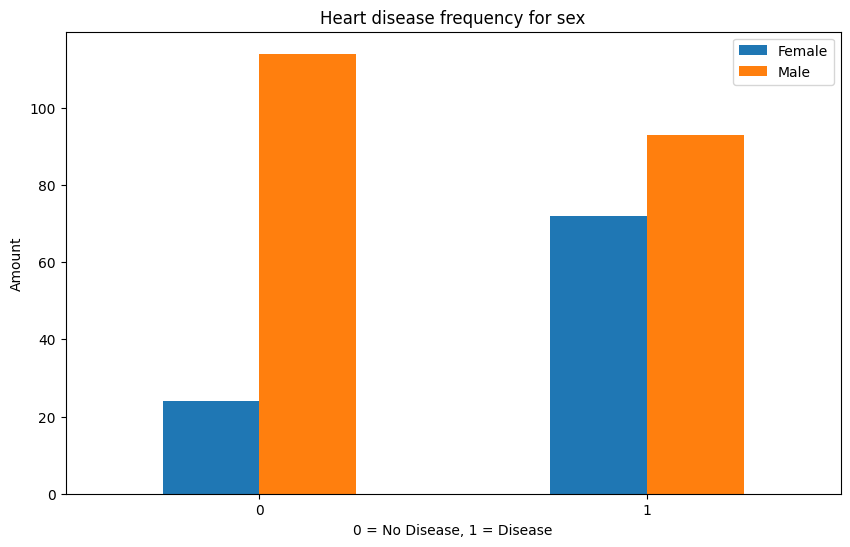

In [13]:
# Visualizing the crosstab
pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(10,6))

plt.title("Heart disease frequency for sex")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.xticks(rotation=0) # Changing the orientation of the x-axis
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);

### Compare the Age to the Max Heart rate

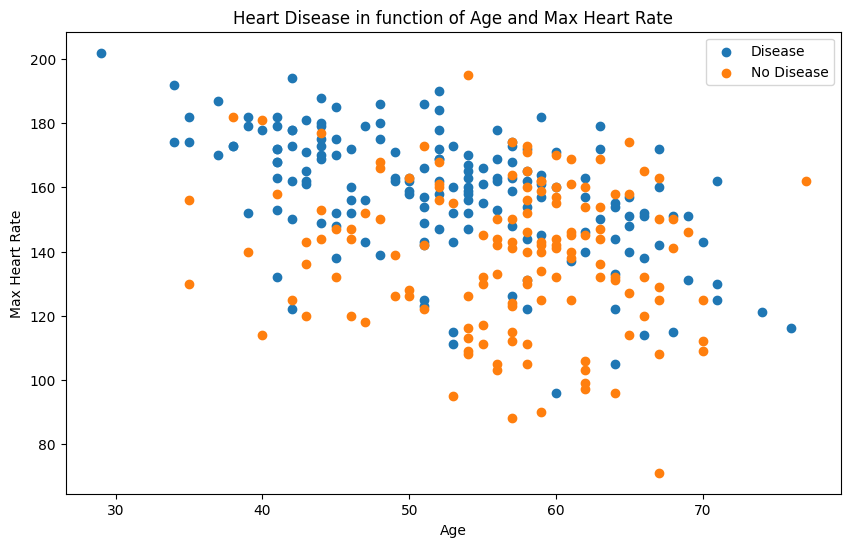

In [14]:
plt.figure(figsize=(10,6))

# Scatter with positive examples (With heart disease)
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
           )

#Scatter with negative examples (without heart disease)
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
           )

# Add some helpful info
plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No Disease"]);

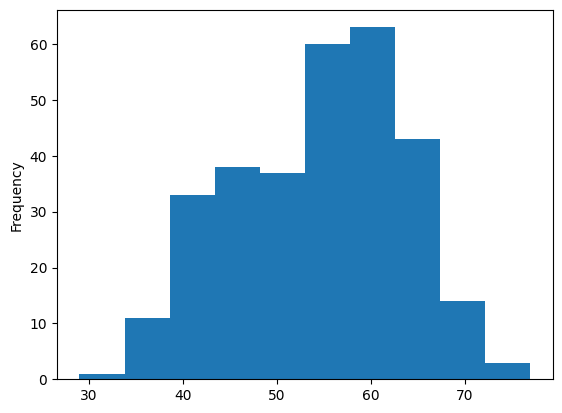

In [15]:
# Checking the distribution of the age column with histogram
df.age.plot.hist();

### Heart disease frequency per Chest pain type
1. cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease

In [16]:
pd.crosstab(df.cp, df.target)

# We seem to have an issue with cp type 2 since its not a heart related disease

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


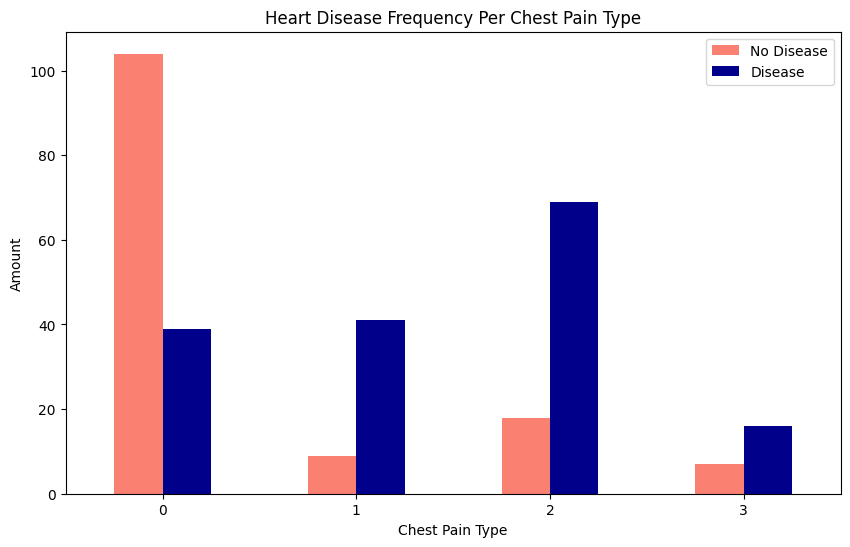

In [17]:
# Visualizing
pd.crosstab(df.cp, df.target).plot(kind="bar", 
                                   figsize=(10, 6), 
                                   color=["salmon", "darkblue"])

# Add some communication
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation=0);

In [18]:
# Make a correlation matrix
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


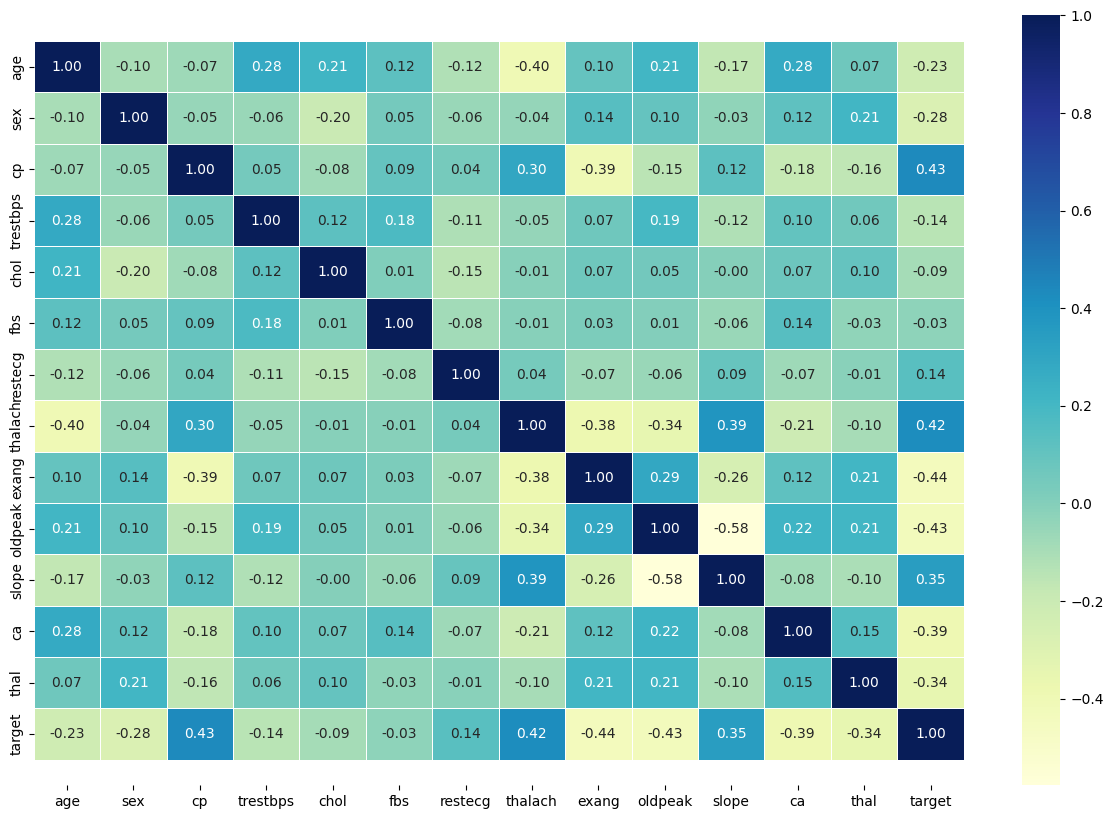

In [19]:
# Let's make the corr matrix a little prettier

corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu");

# https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

### Preparing the datasets for modelling and experimentation

In [20]:
# Split the data into X & y
X = df.drop("target", axis=1)
y = df["target"]

In [21]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [22]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [23]:
np.random.seed(42)

# Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "CatBoost": CatBoostClassifier(verbose=0),
          "XGBoost": xgb.XGBClassifier()
         }

# Creating a function to fit and score the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [24]:
model_scores = fit_and_score(models=models,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)
model_scores

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8524590163934426,
 'CatBoost': 0.8360655737704918,
 'XGBoost': 0.819672131147541}

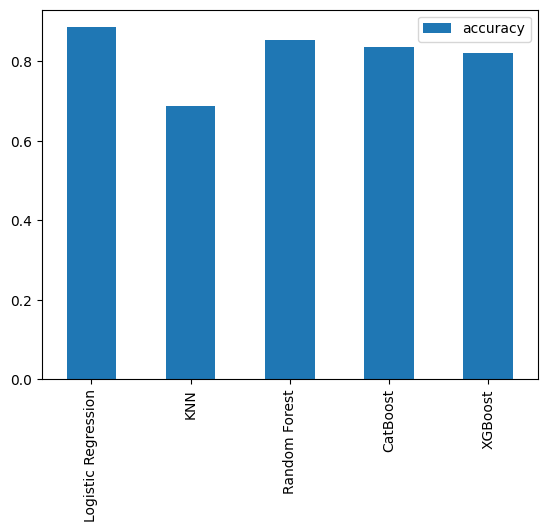

In [25]:
# Comparing model
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

## Hyperparameter tuning with RandomizedSearchCV
We're going to tune:

* LogisticRegression()
* RandomForestClassifier()
* CatBoostClassifier()
* xgb.XGBClassifier()

... using RandomizedSearchCV`

In [26]:
# Create a hyperparameter grid for LogisticRegression
logreg_grid = {"C": np.logspace(-4, 4, 50),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Create a hyperparameter grid for CatBoostClassifier
cat_grid = {'depth': [6,4,5,7,8,9,10],
            'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'learning_rate': [0.03,0.01,0.02,0.04], 
            'l2_leaf_reg': [3,1,5,10,100],}

# Create a hyperparameter grid for XGBClassifier
xgb_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [27]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=logreg_grid,
                                cv=5,
                                n_iter=50,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=50,
                   param_distributions={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-0...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [28]:
# Finding the best hyperparameter
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.18420699693267145}

In [29]:
rs_log_reg.score(X_test, y_test)

0.8852459016393442

In [30]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8524590163934426,
 'CatBoost': 0.8360655737704918,
 'XGBoost': 0.819672131147541}

In [31]:
# Tune RandomForestClassifier()
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=50,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [32]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 260,
 'min_samples_split': 16,
 'min_samples_leaf': 17,
 'max_depth': 3}

In [33]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test, y_test)

0.8688524590163934

In [34]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8524590163934426,
 'CatBoost': 0.8360655737704918,
 'XGBoost': 0.819672131147541}

In [35]:
# Tune XGBClassifier
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for XGBClassifier
xgb_rf = RandomizedSearchCV(xgb.XGBClassifier(), 
                           param_distributions=xgb_grid,
                           cv=5,
                           n_iter=50,
                           verbose=True)

# Fit random hyperparameter search model for XGBClassifier
xgb_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   verbose=True)

In [36]:
# Find the best hyperparameters
xgb_rf.best_params_

{'subsample': 0.8,
 'min_child_weight': 10,
 'max_depth': 3,
 'gamma': 5,
 'colsample_bytree': 1.0}

In [37]:
# Evaluate the randomized search XGBClassifier model
xgb_rf.score(X_test, y_test)

0.8852459016393442

In [38]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8524590163934426,
 'CatBoost': 0.8360655737704918,
 'XGBoost': 0.819672131147541}

## Hyperparamter Tuning with GridSearchCV

In [39]:
# Tune CatBoostClassifier
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for CatBoostClassifier
gs_cat = GridSearchCV(CatBoostClassifier(verbose=0), 
                           param_grid=cat_grid,
                           cv=5,
                           n_jobs=-1)

# Fit random hyperparameter search model for CatBoostClassifier
gs_cat.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x12f390ca0>,
             n_jobs=-1,
             param_grid={'depth': [6, 4, 5, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'l2_leaf_reg': [3, 1, 5, 10, 100],
                         'learning_rate': [0.03, 0.01, 0.02, 0.04]})

In [40]:
# Check the best hyperparmaters
gs_cat.best_params_

{'depth': 6, 'iterations': 20, 'l2_leaf_reg': 3, 'learning_rate': 0.04}

In [41]:
gs_cat.score(X_test, y_test)

0.8688524590163934

In [42]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8524590163934426,
 'CatBoost': 0.8360655737704918,
 'XGBoost': 0.819672131147541}

Since our LogisticRegression model provides the best scores so far, we'll try and improve them again using GridSearchCV...

In [43]:
# Different hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 80),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.26260011e-04, 1.59415904e-04, 2.01278538e-04,
       2.54134304e-04, 3.20870000e-04, 4.05130497e-04, 5.11517810e-04,
       6.45842443e-04, 8.15440740e-04, 1.02957557e-03, 1.29994222e-03,
       1.64130720e-03, 2.07231465e-03, 2.61650470e-03, 3.30359912e-03,
       4.17112461e-03, 5.26646239e-03, 6.649436...
       4.68690419e+01, 5.91768575e+01, 7.47167068e+01, 9.43373222e+01,
       1.19110313e+02, 1.50388695e+02, 1.89880782e+02, 2.39743497e+02,
       3.02700165e+02, 3.82189262e+02, 4.82552204e+02, 6.09270466e+02,
       7.69264957e+02, 9.71274020e+02, 1.22633068e+03, 1.54836526e+03,
       1.95496614e+03, 2.46834047e+03, 3.11652694e+03, 3.93492726e+03,
       4.96823959e+03, 6.27289986e+03, 7.92016405e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [44]:
# Check the best hyperparmaters
gs_log_reg.best_params_

{'C': 0.2196707090793235, 'solver': 'liblinear'}

In [45]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(X_test, y_test)

0.8852459016393442

In [46]:
model_scores

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8524590163934426,
 'CatBoost': 0.8360655737704918,
 'XGBoost': 0.819672131147541}

In [47]:
# Plot ROC curve and calculate and calculate AUC metric
plot_roc_curve(gs_log_reg, X_test, y_test);

TypeError: plot_roc_curve() takes 2 positional arguments but 3 were given

In [48]:
# Make predictions with tuned model
y_preds = gs_log_reg.predict(X_test)
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [49]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[25  4]
 [ 3 29]]


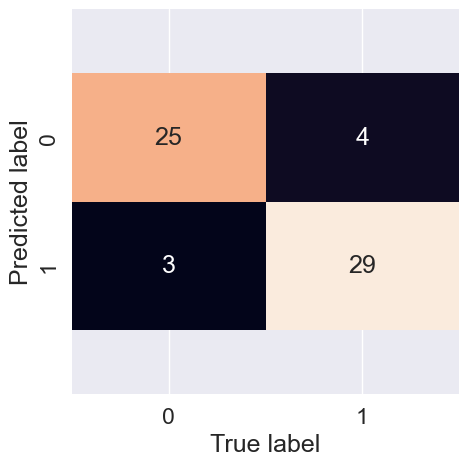

In [50]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_conf_mat(y_test, y_preds)

In [51]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



### Calculate evaluation metrics using cross-validation

In [52]:
# Check best hyperparameters
gs_log_reg.best_params_

{'C': 0.2196707090793235, 'solver': 'liblinear'}

In [53]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=0.2196707090793235,
                         solver="liblinear")

In [54]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc

array([0.81967213, 0.90163934, 0.8852459 , 0.88333333, 0.75      ])

In [55]:
cv_acc = np.mean(cv_acc)
cv_acc

0.8479781420765027

In [56]:
# Cross-validated precision
cv_precision = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="precision")

cv_precision=np.mean(cv_precision)
cv_precision

0.8215873015873015

In [57]:
# Cross-validated recall
cv_recall = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="recall")

cv_recall = np.mean(cv_recall)
cv_recall

0.9272727272727274

In [58]:
# Cross-validated f1-score
cv_f1 = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="f1")

cv_f1 = np.mean(cv_f1)
cv_f1

0.8705403543192143

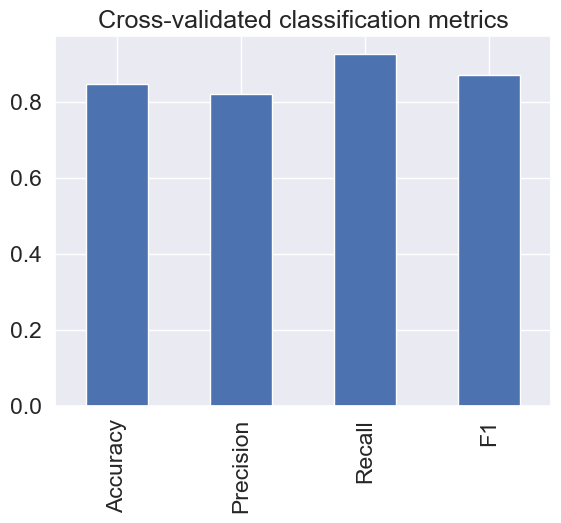

In [59]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      legend=False);

### Feature Importance

In [60]:
# Fit an instance of LogisticRegression
clf = LogisticRegression(C=0.20433597178569418,
                         solver="liblinear")

clf.fit(X_train, y_train);

In [61]:
# Coefficient
clf.coef_

array([[ 0.00316728, -0.86044662,  0.66067038, -0.01156993, -0.00166374,
         0.04386106,  0.31275853,  0.02459361, -0.60413087, -0.56862799,
         0.4505163 , -0.63609901, -0.67663377]])

In [62]:
# Match coef's of features to columns
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031672816664025417,
 'sex': -0.8604466164764594,
 'cp': 0.660670378971457,
 'trestbps': -0.011569931858994414,
 'chol': -0.0016637446649201797,
 'fbs': 0.04386106245399992,
 'restecg': 0.31275852888688666,
 'thalach': 0.024593614591211826,
 'exang': -0.6041308666006405,
 'oldpeak': -0.5686279913648149,
 'slope': 0.45051630416484045,
 'ca': -0.636099010407402,
 'thal': -0.6766337677461476}

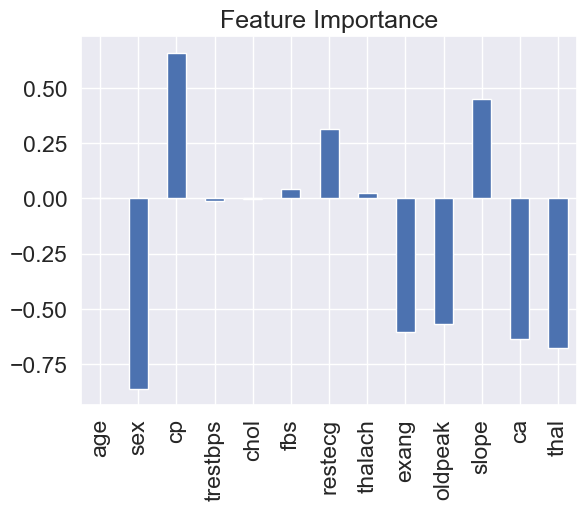

In [63]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

88% was the best I can do at the moment with the skills I have, with a little bit of research will come back and get it to 95%..........